# Inferring Causal Direction from Observational Data:
# A Complexity Approach

## Purpose

This script investigates complexity-based criteria for determining the causal direction from observational data.

The reasoning is that summarizing the dataset by modelling effect from cause (i.e. respecting the direction of the underlying causal mechanism) should be simpler than the other way around, hence the obtained model should be better at compressing the data.

The modelling is performed using decision trees and the criteria investigated explore different ways of measuring model complexity (some limited to trees, some not).

The criteria apply to both continuous and discrete data (although work by first discretizing continuous variables).

## Summary

We first generate artificial data for two variables A & B under a known causal mechanism. We then use the criteria to predict the true causal direction. See the paper or the comments for details.

Import packages:

In [44]:
import numpy as np
import scipy.stats as ss
from sklearn import tree
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mutual_info_score
from matplotlib import pyplot as plt

Experimental Setup:

In [45]:
n_runs = 1000 # Number of runs for each choice of noise variable parameters
n_samples = 1000 # Samples to generate for each distribution

p_B_to_A = 0.5 # Probability that causal direction is B-->A (default: 0.5)
epsilon = 0.000001 # Some small number > 0; prevents division by 0 in normalized J_{RE}

# Data Generation Parameters:
# Discrete '1' or Continuous '0' variables A, B
discrete = 1

# Noise distribution is a Multinomial (Gaussian-Discretized) '0' or Uniform '1'
noise_U_A_distribution = 1 # For the noise variable U_A (practically, for A)
noise_U_B_distribution = 1 # For the noise variable U_B

# Cardinality of values of U_A & U_B
cardinality_U_A = 20 # Increasing it, increases entropy of A, H(A)
cardinality_U_B = 20 # Increasing it, increases entropy of B, H(B)

# Max degree of polynomial (if func_family = 1) or max absolute power (if func_family = 2)
max_degree = 5

# Range of coefficients of polynomial (-coeff_range/2:coeff_range/2+1)
coeff_range = 20

# Multiplicative '0' or Additive '1' noise
additive_noise = 0

# Number of equal width bins to use when converting continuous to discrete
bins_cont_to_discrete = 100 #[TODO: For mixed r.v. pairs, match cardinality of discrete]

Structural Causal Model (SCM):

In [46]:
#f_A defines the function to generate A from some noise (noiseA)
def f_A(noiseA):
	return noiseA #let A simply be noise

#f_B defines the function to generate B from A (varA) & some noise (noiseB), independent of noiseA
# Both noise and dependence of B on A are polynomial
# maximum_degree: Maximum degree of polynomial
# coefficient_range: determines the range of coefficients of the polynomial (-coeff_range/2:coeff_range/2+1)
# add_noise: multiplicative '0' or additive '1' noise 
def f_B(varA, noiseB, maximum_degree, coefficient_range, add_noise):
    
    #FUNC_A: POLY
    degree_func_A = np.random.randint(2,maximum_degree+1)
    coefficients_func_A = np.random.randint(coefficient_range,size=degree_func_A) - (coefficient_range/2)
    if np.count_nonzero(coefficients_func_A[1:]) == 0: # In the rare case func_A is constant w.r.t. A, ...
        coefficients_func_A[np.random.randint(1, degree_func_A)] = np.random.choice(list(range(-coefficient_range,-1))+list(range(1,coefficient_range))) # Make it so it is not
    func_A = np.zeros(len(varA))
    for i in range(degree_func_A):
        func_A = func_A + coefficients_func_A[i] * (varA**i)
    
    #FUNC_NOISE: POLY
    degree_func_noise = np.random.randint(2,maximum_degree+1)
    coefficients_func_noise = np.random.randint(coefficient_range,size=degree_func_noise) - (coefficient_range/2)
    func_noise = np.zeros(len(varA))
    for i in range(degree_func_noise):
        func_noise = func_noise + coefficients_func_noise[i] * (noiseB**i)

    if add_noise==1:
        f = func_A + func_noise
    else: #else use multiplicative noise
        f = func_A * func_noise
    return f

Main script:

In [47]:
true_causal_direction = np.zeros(n_runs)
predicted_causal_direction_J_TD = np.zeros(n_runs)
predicted_causal_direction_J_TN = np.zeros(n_runs)
predicted_causal_direction_J_TL = np.zeros(n_runs)
predicted_causal_direction_J_PL = np.zeros(n_runs)
predicted_causal_direction_J_RE = np.zeros(n_runs)
predicted_causal_direction_J_IH = np.zeros(n_runs)

#Various criteria examined for determining causal direction -- and auxilliary variables:
depth_A_to_B = np.zeros(n_runs) #J_{TD}
depth_B_to_A = np.zeros(n_runs) 
num_nodes_A_to_B = np.zeros(n_runs) #J_{TN}
num_nodes_B_to_A = np.zeros(n_runs)
num_leaves_A_to_B = np.zeros(n_runs) #J_{TL}
num_leaves_B_to_A = np.zeros(n_runs)
mpl_A_to_B = np.zeros(n_runs) #J_{PL}
mpl_B_to_A = np.zeros(n_runs)
H_A_to_B = np.zeros(n_runs) 
H_B_to_A = np.zeros(n_runs) 
H_A = np.zeros(n_runs)
H_B = np.zeros(n_runs)
RE_B_to_A = np.zeros(n_runs) #J_{RE}
RE_A_to_B = np.zeros(n_runs)
accuracy_A_to_B = np.zeros(n_runs) #J_{IH}
accuracy_B_to_A = np.zeros(n_runs)

for run in range(n_runs):

    #----------------------------Generate dataset:-----------------------------
    
    # First generate independent noise variables; 
    
    if discrete == 1:
        # If these are to be discrete r.v.s, then use either a uniform distribution or a discretized Gaussian
        if noise_U_A_distribution == 1:
            U_A = np.random.randint(cardinality_U_A,size=n_samples) - (cardinality_U_A/2)
        else: # If noise_U_A_distribution == 0, use a discretized Gaussian      
            x = np.arange(-(cardinality_U_A/2), (cardinality_U_A + 1))
            xU, xL = x + 0.5, x - 0.5 
            prob = ss.norm.cdf(xU, scale = 3) - ss.norm.cdf(xL, scale = 3)
            prob = prob / prob.sum() #normalize the probabilities so their sum is 1
            U_A = np.random.choice(x, size = n_samples, p = prob)
        
        if noise_U_B_distribution == 1:
            U_B = np.random.randint(cardinality_U_B,size=n_samples) - (cardinality_U_B/2)
        else: # If noise_U_B_distribution == 0, use a discretized Gaussian
            x = np.arange(-(cardinality_U_B/2), (cardinality_U_B + 1))
            xU, xL = x + 0.5, x - 0.5 
            prob = ss.norm.cdf(xU, scale = 3) - ss.norm.cdf(xL, scale = 3)
            prob = prob / prob.sum() #normalize the probabilities so their sum is 1
            U_B = np.random.choice(x, size = n_samples, p = prob)
    else:
        # If these are to be continuous r.v.s, then use either a uniform distribution or a discretized Gaussian
        if noise_U_A_distribution == 1:
            U_A = np.random.uniform(low=-1.0, high=1.0, size=n_samples)
        else:
            U_A = np.random.normal(loc=0.0, scale=1.0, size=n_samples)
        if noise_U_B_distribution == 1:    
            U_B = np.random.uniform(low=-1.0, high=1.0, size=n_samples)
        else:
            U_B = np.random.normal(loc=0.0, scale=1.0, size=n_samples)  
    
    # Now generate observable variables A & B according to SCM using the noise variables:
    A = f_A(U_A)                                 
    B = f_B(A, U_B, max_degree, coeff_range, additive_noise)                  
    
    #Flip causal direction to B-->A, with probability p_B_to_A, by swapping A & B: 
    if np.random.uniform(0,1) > 1 - p_B_to_A:
        temp = A
        A = B
        B = temp
        true_causal_direction[run] = 2
    else:
        true_causal_direction[run] = 1
        
    #Discretize, if continuous
    if discrete == 0:
        from sklearn.preprocessing import KBinsDiscretizer
        discretizer = KBinsDiscretizer(n_bins=bins_cont_to_discrete, encode='ordinal', strategy='uniform')
        A = discretizer.fit_transform(A.reshape(-1, 1))
        B = discretizer.fit_transform(B.reshape(-1, 1))
        
    #--------------------------Train Models:----------------------------
  
    A_train = A.reshape(-1, 1)
    B_train = B.reshape(-1, 1)  
    
    clf_A_to_B = tree.DecisionTreeClassifier()
    clf_B_to_A = tree.DecisionTreeClassifier()
        
    clf_A_to_B = clf_A_to_B.fit(A_train, B_train)
    clf_B_to_A = clf_B_to_A.fit(B_train, A_train)   

    #-------------------------Obtain Model Scores:-----------------------------

    predictions_A_to_B = clf_A_to_B.predict(A_train)   
    predictions_B_to_A = clf_B_to_A.predict(B_train)   
    
    #-----------------Measure Trained Models' Complexity:----------------------
    
    #Criterion: Tree Depth
    depth_A_to_B[run] = clf_A_to_B.get_depth()
    depth_B_to_A[run] = clf_B_to_A.get_depth()

    #Criterion: Tree Nodes
    num_nodes_A_to_B[run] = clf_A_to_B.tree_.node_count
    num_nodes_B_to_A[run] = clf_B_to_A.tree_.node_count 
    
    #Criterion: Tree Leaves 
    num_leaves_A_to_B[run] = clf_A_to_B.get_n_leaves()
    num_leaves_B_to_A[run] = clf_B_to_A.get_n_leaves()   
 
    #Criterion: Mean Path Length
    #First compute all paths:
    paths_A_to_B = clf_A_to_B.decision_path(A_train).todense()
    paths_B_to_A = clf_B_to_A.decision_path(B_train).todense()
    #Then get mean path length:
    mpl_A_to_B[run] = np.mean(np.sum(paths_A_to_B, axis=1))
    mpl_B_to_A[run] = np.mean(np.sum(paths_B_to_A, axis=1))
 
    #Criterion: Interpolation Hardness
    accuracy_A_to_B[run] = accuracy_score(predictions_A_to_B, B_train.ravel())
    accuracy_B_to_A[run] = accuracy_score(predictions_B_to_A, A_train.ravel())
        
    #Criterion: Residual Entropy
    #First estimate entropy of target:
    H_A[run] = mutual_info_score(A_train.ravel(), A_train.ravel()) #drv.entropy(A_train.ravel(), estimator=entropy_estimator)
    H_B[run] = mutual_info_score(B_train.ravel(), B_train.ravel()) #drv.entropy(B_train.ravel(), estimator=entropy_estimator)
    #Then estimate entropy of the residuals after approximation of target:
    H_A_to_B[run] = mutual_info_score(B_train.ravel() - predictions_A_to_B, B_train.ravel() - predictions_A_to_B) #drv.entropy(B_train.ravel() - predictions_A_to_B, estimator=entropy_estimator)
    H_B_to_A[run] = mutual_info_score(A_train.ravel() - predictions_B_to_A, A_train.ravel() - predictions_B_to_A) #drv.entropy(A_train.ravel() - predictions_B_to_A, estimator=entropy_estimator)
    #Measure difference -- unnormalized
#    RE_B_to_A[run] = H_A[run] - H_B_to_A[run]  # Decrease in entropy from A to residuals A-A_hat, A_hat = f(B)
#    RE_A_to_B[run] = H_B[run] - H_A_to_B[run]  # Decrease in entropy from B to residuals B-B_hat, B_hat = g(A)
    #Measure difference -- normalized
    RE_B_to_A[run] = (H_A[run] - H_B_to_A[run]) / max(H_A[run], epsilon)
    RE_A_to_B[run] = (H_B[run] - H_A_to_B[run]) / max(H_B[run], epsilon)

    #Predict causal direction using each criterion:
    
    #J_TD, Tree Depth
    if depth_B_to_A[run] > depth_A_to_B[run]:
        predicted_causal_direction_J_TD[run] = 1 #predict A-->B
    elif depth_B_to_A[run] < depth_A_to_B[run]:
        predicted_causal_direction_J_TD[run] = 2 #predict B-->A
    #Otherwise, abstain from predicting 
    
    #J_TN, Tree Nodes
    if num_nodes_B_to_A[run] > num_nodes_A_to_B[run]:
        predicted_causal_direction_J_TN[run] = 1 #predict A-->B
    elif num_nodes_B_to_A[run] < num_nodes_A_to_B[run]:
        predicted_causal_direction_J_TN[run] = 2 #predict B-->A
    #Otherwise, abstain from predicting  
    
    #J_TL, Tree Leaves
    if num_leaves_B_to_A[run] > num_leaves_A_to_B[run]:
        predicted_causal_direction_J_TL[run] = 1 #predict A-->B
    elif num_leaves_B_to_A[run] < num_leaves_A_to_B[run]:
        predicted_causal_direction_J_TL[run] = 2 #predict B-->A
    #Otherwise, abstain from predicting     

    #J_PL, Path Length
    if mpl_B_to_A[run] > mpl_A_to_B[run]:
        predicted_causal_direction_J_PL[run] = 1 #predict A-->B
    elif mpl_B_to_A[run] < mpl_A_to_B[run]:
        predicted_causal_direction_J_PL[run] = 2 #predict B-->A
    #Otherwise, abstain from predicting    
    
    #J_RE, Residual Entropy
    if RE_B_to_A[run] > RE_A_to_B[run]:
        predicted_causal_direction_J_RE[run] = 1 #predict A-->B
    elif RE_B_to_A[run] < RE_A_to_B[run]:
        predicted_causal_direction_J_RE[run] = 2 #predict B-->A
    #Otherwise, abstain from predicting
    
    #J_IH, Interpolation Hardness
    if accuracy_B_to_A[run] > accuracy_A_to_B[run]:
        predicted_causal_direction_J_IH[run] = 1 #predict A-->B
    elif accuracy_B_to_A[run] < accuracy_A_to_B[run]:
        predicted_causal_direction_J_IH[run] = 2 #predict B-->A
    #Otherwise, abstain from predicting   

Calculate quantities of interest:

In [48]:
#Compute mean value of each criterion for causal & anti-causal direction:

#Count true direction cases (should be roughly equal):
count_A_to_B = np.count_nonzero(true_causal_direction == 1)
count_B_to_A = n_samples - count_A_to_B

#J_TD, Tree Depth
depth_A_to_B_mean_1 = np.nanmean(depth_A_to_B[np.where(true_causal_direction==1)])
depth_B_to_A_mean_1 = np.nanmean(depth_B_to_A[np.where(true_causal_direction==1)])
depth_A_to_B_mean_2 = np.nanmean(depth_A_to_B[np.where(true_causal_direction==2)])
depth_B_to_A_mean_2 = np.nanmean(depth_B_to_A[np.where(true_causal_direction==2)])  

depth_causal = (count_A_to_B*depth_A_to_B_mean_1 + count_B_to_A*depth_B_to_A_mean_2) / n_samples
depth_anticausal = (count_A_to_B*depth_A_to_B_mean_2 + count_B_to_A*depth_B_to_A_mean_1) / n_samples

#J_TN, Tree Nodes
num_nodes_A_to_B_mean_1 = np.nanmean(num_nodes_A_to_B[np.where(true_causal_direction==1)])
num_nodes_B_to_A_mean_1 = np.nanmean(num_nodes_B_to_A[np.where(true_causal_direction==1)])
num_nodes_A_to_B_mean_2 = np.nanmean(num_nodes_A_to_B[np.where(true_causal_direction==2)])
num_nodes_B_to_A_mean_2 = np.nanmean(num_nodes_B_to_A[np.where(true_causal_direction==2)]) 

num_nodes_causal = (count_A_to_B*num_nodes_A_to_B_mean_1 + count_B_to_A*num_nodes_B_to_A_mean_2) / n_samples
num_nodes_anticausal = (count_A_to_B*num_nodes_A_to_B_mean_2 + count_B_to_A*num_nodes_B_to_A_mean_1) / n_samples

#J_TL, Tree Leaves
num_leaves_A_to_B_mean_1 = np.nanmean(num_leaves_A_to_B[np.where(true_causal_direction==1)])
num_leaves_B_to_A_mean_1 = np.nanmean(num_leaves_B_to_A[np.where(true_causal_direction==1)])
num_leaves_A_to_B_mean_2 = np.nanmean(num_leaves_A_to_B[np.where(true_causal_direction==2)])
num_leaves_B_to_A_mean_2 = np.nanmean(num_leaves_B_to_A[np.where(true_causal_direction==2)]) 

num_leaves_causal = (count_A_to_B*num_leaves_A_to_B_mean_1 + count_B_to_A*num_leaves_B_to_A_mean_2) / n_samples
num_leaves_anticausal = (count_A_to_B*num_leaves_A_to_B_mean_2 + count_B_to_A*num_leaves_B_to_A_mean_1) / n_samples

#J_PL, Path Length
mpl_A_to_B_mean_1 = np.nanmean(mpl_A_to_B[np.where(true_causal_direction==1)])
mpl_B_to_A_mean_1 = np.nanmean(mpl_B_to_A[np.where(true_causal_direction==1)])
mpl_A_to_B_mean_2 = np.nanmean(mpl_A_to_B[np.where(true_causal_direction==2)])
mpl_B_to_A_mean_2 = np.nanmean(mpl_B_to_A[np.where(true_causal_direction==2)])  

mpl_causal = (count_A_to_B*mpl_A_to_B_mean_1 + count_B_to_A*mpl_B_to_A_mean_2) / n_samples
mpl_anticausal = (count_A_to_B*mpl_A_to_B_mean_2 + count_B_to_A*mpl_B_to_A_mean_1) / n_samples

#J_RE, Residual Entropy
RE_A_to_B_mean_1 = np.nanmean(RE_A_to_B[np.where(true_causal_direction==1)])
RE_B_to_A_mean_1 = np.nanmean(RE_B_to_A[np.where(true_causal_direction==1)])
RE_A_to_B_mean_2 = np.nanmean(RE_A_to_B[np.where(true_causal_direction==2)])
RE_B_to_A_mean_2 = np.nanmean(RE_B_to_A[np.where(true_causal_direction==2)])

RE_causal = (count_A_to_B*RE_A_to_B_mean_1 + count_B_to_A*RE_B_to_A_mean_2) / n_samples
RE_anticausal = (count_A_to_B*RE_A_to_B_mean_2 + count_B_to_A*RE_B_to_A_mean_1) / n_samples

#J_IH, Interpolation Hardness
accuracy_A_to_B_mean_1 = np.nanmean(accuracy_A_to_B[np.where(true_causal_direction==1)])
accuracy_B_to_A_mean_1 = np.nanmean(accuracy_B_to_A[np.where(true_causal_direction==1)])
accuracy_A_to_B_mean_2 = np.nanmean(accuracy_A_to_B[np.where(true_causal_direction==2)])
accuracy_B_to_A_mean_2 = np.nanmean(accuracy_B_to_A[np.where(true_causal_direction==2)])
    
accuracy_causal = (count_A_to_B*accuracy_A_to_B_mean_1 + count_B_to_A*accuracy_B_to_A_mean_2) / (count_A_to_B + count_B_to_A)
accuracy_anticausal = (count_A_to_B*accuracy_A_to_B_mean_2 + count_B_to_A*accuracy_B_to_A_mean_1) / (count_A_to_B + count_B_to_A)

#Evaluate the accuracy of the criteria:

#J_TD, Tree Depth
conf_mat_J_TD = confusion_matrix(true_causal_direction, predicted_causal_direction_J_TD)
accuracy_J_TD = np.trace(conf_mat_J_TD)/np.sum(conf_mat_J_TD)

if conf_mat_J_TD.shape[0] == 3: # if criterion abstained at least once
    accuracy_when_not_abstaining_J_TD = np.trace(conf_mat_J_TD)/np.sum(conf_mat_J_TD[1:,1:])
else:
    accuracy_when_not_abstaining_J_TD = accuracy_J_TD
    
#J_TN, Tree Nodes
conf_mat_J_TN = confusion_matrix(true_causal_direction, predicted_causal_direction_J_TN)
accuracy_J_TN = np.trace(conf_mat_J_TN)/np.sum(conf_mat_J_TN)

if conf_mat_J_TN.shape[0] == 3: # if criterion abstained at least once
    accuracy_when_not_abstaining_J_TN = np.trace(conf_mat_J_TN)/np.sum(conf_mat_J_TN[1:,1:])
else:
    accuracy_when_not_abstaining_J_TN = accuracy_J_TN
    
#J_TL, Tree Leaves
conf_mat_J_TL = confusion_matrix(true_causal_direction, predicted_causal_direction_J_TL)
accuracy_J_TL = np.trace(conf_mat_J_TL)/np.sum(conf_mat_J_TL)

if conf_mat_J_TL.shape[0] == 3: # if criterion abstained at least once
    accuracy_when_not_abstaining_J_TL = np.trace(conf_mat_J_TL)/np.sum(conf_mat_J_TL[1:,1:])
else:
    accuracy_when_not_abstaining_J_TL = accuracy_J_TL
    
#J_PL, Path Length
conf_mat_J_PL = confusion_matrix(true_causal_direction, predicted_causal_direction_J_PL)
accuracy_J_PL = np.trace(conf_mat_J_PL)/np.sum(conf_mat_J_PL)

if conf_mat_J_PL.shape[0] == 3: # if criterion abstained at least once
    accuracy_when_not_abstaining_J_PL = np.trace(conf_mat_J_PL)/np.sum(conf_mat_J_PL[1:,1:])
else:
    accuracy_when_not_abstaining_J_PL = accuracy_J_PL
    
#J_RE, Residual Entropy
conf_mat_J_RE = confusion_matrix(true_causal_direction, predicted_causal_direction_J_RE)
accuracy_J_RE = np.trace(conf_mat_J_RE)/np.sum(conf_mat_J_RE)

if conf_mat_J_RE.shape[0] == 3: # if criterion abstained at least once
    accuracy_when_not_abstaining_J_RE = np.trace(conf_mat_J_RE)/np.sum(conf_mat_J_RE[1:,1:])
else:
    accuracy_when_not_abstaining_J_RE = accuracy_J_RE
    
#J_IH, Interpolation Hardness
conf_mat_J_IH = confusion_matrix(true_causal_direction, predicted_causal_direction_J_IH)
accuracy_J_IH = np.trace(conf_mat_J_IH)/np.sum(conf_mat_J_IH)

if conf_mat_J_IH.shape[0] == 3: # if criterion abstained at least once
    accuracy_when_not_abstaining_J_IH = np.trace(conf_mat_J_IH)/np.sum(conf_mat_J_IH[1:,1:])
else:
    accuracy_when_not_abstaining_J_IH = accuracy_J_IH

Print quantities of intrest:

In [49]:
print("Tree Depth (TD)")
print("Average TD (causal directionality): " +str(depth_causal))
print("Average TD (anticausal directionality): " +str(depth_anticausal))
print("Accuracy: " + str(accuracy_J_TD))
print("Accuracy when not abstaining: " + str(accuracy_when_not_abstaining_J_TD))

print("Tree Nodes (TN)")
print("Average TN (causal directionality): " +str(num_nodes_causal))
print("Average TN (anticausal directionality): " +str(num_nodes_anticausal))
print("Accuracy: " + str(accuracy_J_TN))
print("Accuracy when not abstaining: " + str(accuracy_when_not_abstaining_J_TN))

print("Tree Leaves (TL)")
print("Average TL (causal directionality): " +str(num_leaves_causal))
print("Average TL (anticausal directionality): " +str(num_leaves_anticausal))
print("Accuracy: " + str(accuracy_J_TL))
print("Accuracy when not abstaining: " + str(accuracy_when_not_abstaining_J_TL))

print("Mean Path Length of Tree (PL) -- i.e. average depth traversed by training set points")
print("Average PL (causal directionality): " +str(mpl_causal))
print("Average PL (anticausal directionality): " +str(mpl_anticausal))
print("Accuracy: " + str(accuracy_J_PL))
print("Accuracy when not abstaining: " + str(accuracy_when_not_abstaining_J_PL))

print("Residual Entropy (RE)")
print("Average RE (causal directionality): " +str(RE_causal))
print("Average RE (anticausal directionality): " +str(RE_anticausal))
print("Accuracy: " + str(accuracy_J_RE))
print("Accuracy when not abstaining: " + str(accuracy_when_not_abstaining_J_RE))

print("Misclassification Error (IH)")
print("Average Error (IH) (causal directionality): " +str(1-accuracy_causal))
print("Average Error (IH) (anticausal directionality): " +str(1-accuracy_anticausal))
print("Accuracy: " + str(accuracy_J_IH))
print("Accuracy when not abstaining: " + str(accuracy_when_not_abstaining_J_IH))

Tree Depth (TD)
Average TD (causal directionality): 9.084
Average TD (anticausal directionality): 27.09715945928631
Accuracy: 0.991
Accuracy when not abstaining: 0.9969818913480886
Tree Nodes (TN)
Average TN (causal directionality): 38.996
Average TN (anticausal directionality): 615.0668346466782
Accuracy: 0.99
Accuracy when not abstaining: 0.9979838709677419
Tree Leaves (TL)
Average TL (causal directionality): 19.998
Average TL (anticausal directionality): 308.0334173233391
Accuracy: 0.99
Accuracy when not abstaining: 0.9979838709677419
Mean Path Length of Tree (PL) -- i.e. average depth traversed by training set points
Average PL (causal directionality): 6.809374
Average PL (anticausal directionality): 13.77446506002947
Accuracy: 0.991
Accuracy when not abstaining: 0.9959798994974874
Residual Entropy (RE)
Average RE (causal directionality): 0.06980584749788948
Average RE (anticausal directionality): 0.8998856855992865
Accuracy: 0.99
Accuracy when not abstaining: 0.9979838709677419
Mi

Scatter-plots of criteria scores for tree A --> B and tree B --> A (omitted from paper):

Text(0, 0.5, 'Accuracy of tree B-->A')

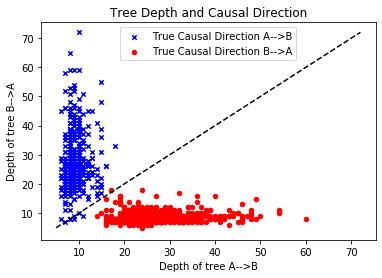

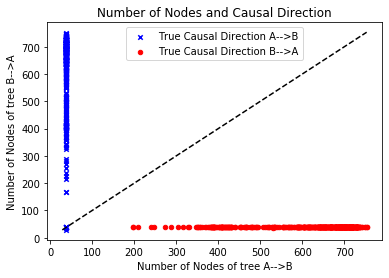

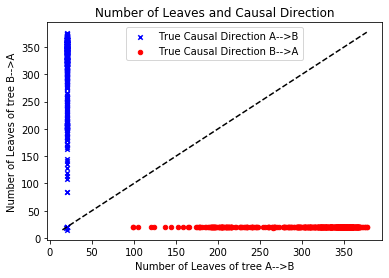

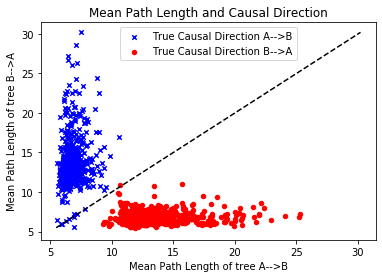

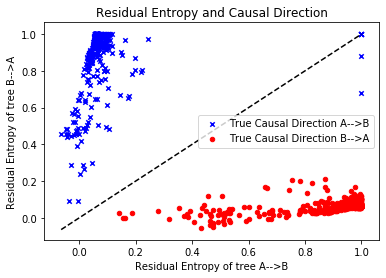

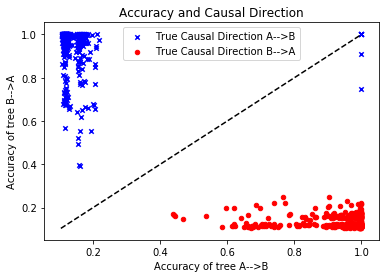

In [50]:
group = true_causal_direction
cdict = {1: 'blue', 2: 'red'}
mdict = {1: 'x', 2: 'o'}
fig_labels = {1: 'True Causal Direction A-->B', 2: 'True Causal Direction B-->A'}

scatter_x = depth_A_to_B
scatter_y = depth_B_to_A
fig, ax = plt.subplots()
for g in np.unique(group):
   ix = np.where(group == g)
   ax.scatter(scatter_x[ix], scatter_y[ix], c = cdict[g], marker = mdict[g], label = fig_labels[g], s = 20)
ax.legend()
plt.plot([min(np.nanmin(scatter_x), np.nanmin(scatter_y)), max(np.nanmax(scatter_x), np.nanmax(scatter_y))],[min(np.nanmin(scatter_x), np.nanmin(scatter_y)), max(np.nanmax(scatter_x), np.nanmax(scatter_y))], color = 'k', linestyle = '--')
plt.title("Tree Depth and Causal Direction")
plt.xlabel("Depth of tree A-->B")
plt.ylabel("Depth of tree B-->A")

scatter_x = num_nodes_A_to_B
scatter_y = num_nodes_B_to_A
fig, ax = plt.subplots()
for g in np.unique(group):
   ix = np.where(group == g)
   ax.scatter(scatter_x[ix], scatter_y[ix], c = cdict[g], marker = mdict[g], label = fig_labels[g], s = 20)
ax.legend()
plt.plot([min(np.nanmin(scatter_x), np.nanmin(scatter_y)), max(np.nanmax(scatter_x), np.nanmax(scatter_y))],[min(np.nanmin(scatter_x), np.nanmin(scatter_y)), max(np.nanmax(scatter_x), np.nanmax(scatter_y))], color = 'k', linestyle = '--')
plt.title("Number of Nodes and Causal Direction")
plt.xlabel("Number of Nodes of tree A-->B")
plt.ylabel("Number of Nodes of tree B-->A")

scatter_x = num_leaves_A_to_B
scatter_y = num_leaves_B_to_A
fig, ax = plt.subplots()
for g in np.unique(group):
   ix = np.where(group == g)
   ax.scatter(scatter_x[ix], scatter_y[ix], c = cdict[g], marker = mdict[g], label = fig_labels[g], s = 20)
ax.legend()
plt.plot([min(np.nanmin(scatter_x), np.nanmin(scatter_y)), max(np.nanmax(scatter_x), np.nanmax(scatter_y))],[min(np.nanmin(scatter_x), np.nanmin(scatter_y)), max(np.nanmax(scatter_x), np.nanmax(scatter_y))], color = 'k', linestyle = '--')
plt.title("Number of Leaves and Causal Direction")
plt.xlabel("Number of Leaves of tree A-->B")
plt.ylabel("Number of Leaves of tree B-->A")

scatter_x = mpl_A_to_B
scatter_y = mpl_B_to_A
fig, ax = plt.subplots()
for g in np.unique(group):
   ix = np.where(group == g)
   ax.scatter(scatter_x[ix], scatter_y[ix], c = cdict[g], marker = mdict[g], label = fig_labels[g], s = 20)
ax.legend()
plt.plot([min(np.nanmin(scatter_x), np.nanmin(scatter_y)), max(np.nanmax(scatter_x), np.nanmax(scatter_y))],[min(np.nanmin(scatter_x), np.nanmin(scatter_y)), max(np.nanmax(scatter_x), np.nanmax(scatter_y))], color = 'k', linestyle = '--')
plt.title("Mean Path Length and Causal Direction")
plt.xlabel("Mean Path Length of tree A-->B")
plt.ylabel("Mean Path Length of tree B-->A")

scatter_x = RE_A_to_B
scatter_y = RE_B_to_A
fig, ax = plt.subplots()
for g in np.unique(group):
   ix = np.where(group == g)
   ax.scatter(scatter_x[ix], scatter_y[ix], c = cdict[g], marker = mdict[g], label = fig_labels[g], s = 20)
ax.legend()
plt.plot([min(np.nanmin(scatter_x), np.nanmin(scatter_y)), max(np.nanmax(scatter_x), np.nanmax(scatter_y))],[min(np.nanmin(scatter_x), np.nanmin(scatter_y)), max(np.nanmax(scatter_x), np.nanmax(scatter_y))], color = 'k', linestyle = '--')
plt.title("Residual Entropy and Causal Direction")
plt.xlabel("Residual Entropy of tree A-->B")
plt.ylabel("Residual Entropy of tree B-->A")

scatter_x = accuracy_A_to_B
scatter_y = accuracy_B_to_A
fig, ax = plt.subplots()
for g in np.unique(group):
    ix = np.where(group == g)
    ax.scatter(scatter_x[ix], scatter_y[ix], c = cdict[g], marker = mdict[g], label = fig_labels[g], s = 20)
ax.legend()
plt.plot([min(np.nanmin(scatter_x), np.nanmin(scatter_y)), max(np.nanmax(scatter_x), np.nanmax(scatter_y))],[min(np.nanmin(scatter_x), np.nanmin(scatter_y)), max(np.nanmax(scatter_x), np.nanmax(scatter_y))], color = 'k', linestyle = '--')
plt.title("Accuracy and Causal Direction")
plt.xlabel("Accuracy of tree A-->B")
plt.ylabel("Accuracy of tree B-->A")

Plot histograms of criteria value for causal & anticausal direction models:

Text(0, 0.5, 'Frequency')

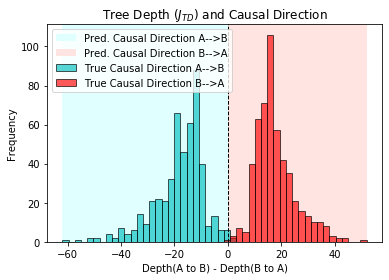

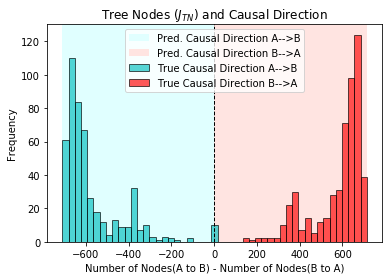

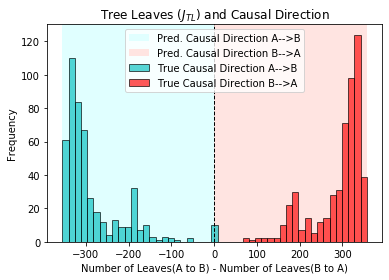

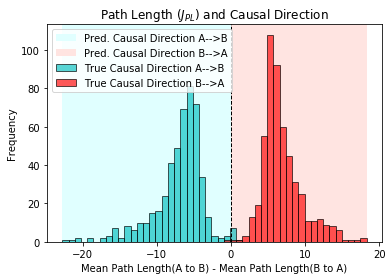

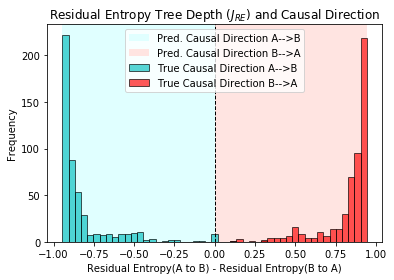

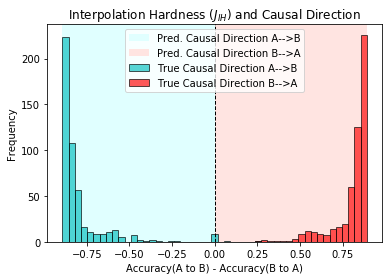

In [51]:
plt.figure(1)
x = depth_A_to_B - depth_B_to_A
bins_x = np.linspace(np.nanmin(x), np.nanmax(x), 50)
plt.axvspan(np.nanmin(x), 0, facecolor='lightcyan')
plt.axvspan(0, np.nanmax(x), facecolor='mistyrose')
plt.hist(x[np.where(true_causal_direction==1)], bins=bins_x, color='c', edgecolor='k', alpha=0.65)
plt.hist(x[np.where(true_causal_direction==2)], bins=bins_x, color='r', edgecolor='k', alpha=0.65)
plt.legend(('Pred. Causal Direction A-->B', 'Pred. Causal Direction B-->A', 'True Causal Direction A-->B', 'True Causal Direction B-->A'))
plt.axvline(0, color='k', linestyle='dashed', linewidth=1)
plt.title("Tree Depth ($J_{TD}$) and Causal Direction")
plt.xlabel("Depth(A to B) - Depth(B to A)")
plt.ylabel("Frequency")

plt.figure(2)
x = num_nodes_A_to_B - num_nodes_B_to_A
bins_x = np.linspace(np.nanmin(x), np.nanmax(x), 50)
plt.axvspan(np.nanmin(x), 0, facecolor='lightcyan')
plt.axvspan(0, np.nanmax(x), facecolor='mistyrose')
plt.hist(x[np.where(true_causal_direction==1)], bins=bins_x, color='c', edgecolor='k', alpha=0.65)
plt.hist(x[np.where(true_causal_direction==2)], bins=bins_x, color='r', edgecolor='k', alpha=0.65)
plt.legend(('Pred. Causal Direction A-->B', 'Pred. Causal Direction B-->A', 'True Causal Direction A-->B', 'True Causal Direction B-->A'))
plt.axvline(0, color='k', linestyle='dashed', linewidth=1)
plt.title("Tree Nodes ($J_{TN}$) and Causal Direction")
plt.xlabel("Number of Nodes(A to B) - Number of Nodes(B to A)")
plt.ylabel("Frequency")

plt.figure(3)
x = num_leaves_A_to_B - num_leaves_B_to_A
bins_x = np.linspace(np.nanmin(x), np.nanmax(x), 50)
plt.axvspan(np.nanmin(x), 0, facecolor='lightcyan')
plt.axvspan(0, np.nanmax(x), facecolor='mistyrose')
plt.hist(x[np.where(true_causal_direction==1)], bins=bins_x, color='c', edgecolor='k', alpha=0.65)
plt.hist(x[np.where(true_causal_direction==2)], bins=bins_x, color='r', edgecolor='k', alpha=0.65)
plt.legend(('Pred. Causal Direction A-->B', 'Pred. Causal Direction B-->A', 'True Causal Direction A-->B', 'True Causal Direction B-->A'))
plt.axvline(0, color='k', linestyle='dashed', linewidth=1)
plt.title("Tree Leaves ($J_{TL}$) and Causal Direction")
plt.xlabel("Number of Leaves(A to B) - Number of Leaves(B to A)")
plt.ylabel("Frequency")

plt.figure(4)
x = mpl_A_to_B - mpl_B_to_A
bins_x = np.linspace(np.nanmin(x), np.nanmax(x), 50)
plt.axvspan(np.nanmin(x), 0, facecolor='lightcyan')
plt.axvspan(0, np.nanmax(x), facecolor='mistyrose')
plt.hist(x[np.where(true_causal_direction==1)], bins=bins_x, color='c', edgecolor='k', alpha=0.65)
plt.hist(x[np.where(true_causal_direction==2)], bins=bins_x, color='r', edgecolor='k', alpha=0.65)
plt.legend(('Pred. Causal Direction A-->B', 'Pred. Causal Direction B-->A', 'True Causal Direction A-->B', 'True Causal Direction B-->A'))
plt.axvline(0, color='k', linestyle='dashed', linewidth=1)
plt.title("Path Length ($J_{PL}$) and Causal Direction")
plt.xlabel("Mean Path Length(A to B) - Mean Path Length(B to A)")
plt.ylabel("Frequency")

plt.figure(5)
x = RE_A_to_B - RE_B_to_A
bins_x = np.linspace(np.nanmin(x), np.nanmax(x), 50)
plt.axvspan(np.nanmin(x), 0, facecolor='lightcyan')
plt.axvspan(0, np.nanmax(x), facecolor='mistyrose')
plt.hist(x[np.where(true_causal_direction==1)], bins=bins_x, color='c', edgecolor='k', alpha=0.65)
plt.hist(x[np.where(true_causal_direction==2)], bins=bins_x, color='r', edgecolor='k', alpha=0.65)
plt.legend(('Pred. Causal Direction A-->B', 'Pred. Causal Direction B-->A', 'True Causal Direction A-->B', 'True Causal Direction B-->A'))
plt.axvline(0, color='k', linestyle='dashed', linewidth=1)
plt.title("Residual Entropy Tree Depth ($J_{RE}$) and Causal Direction")
plt.xlabel("Residual Entropy(A to B) - Residual Entropy(B to A)")
plt.ylabel("Frequency")

plt.figure(6)
x = accuracy_A_to_B - accuracy_B_to_A
bins_x = np.linspace(np.nanmin(x), np.nanmax(x), 50)
plt.axvspan(np.nanmin(x), 0, facecolor='lightcyan')
plt.axvspan(0, np.nanmax(x), facecolor='mistyrose')
plt.hist(x[np.where(true_causal_direction==1)], bins=bins_x, color='c', edgecolor='k', alpha=0.65)
plt.hist(x[np.where(true_causal_direction==2)], bins=bins_x, color='r', edgecolor='k', alpha=0.65)
plt.legend(('Pred. Causal Direction A-->B', 'Pred. Causal Direction B-->A', 'True Causal Direction A-->B', 'True Causal Direction B-->A'))
plt.axvline(0, color='k', linestyle='dashed', linewidth=1)
plt.title("Interpolation Hardness ($J_{IH}$) and Causal Direction")
plt.xlabel("Accuracy(A to B) - Accuracy(B to A)")
plt.ylabel("Frequency")